In [1]:
# Importing all the libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import re
import os
from os import listdir
from os.path import isfile, join

In [2]:
# Function responsible for reading a csv/txt file, given by the universal testing machine (may vary from machine to machine)
def getData(data):
    df = pd.read_csv(data, skiprows=9, skipfooter=37, delimiter='\t', engine='python')
    df.drop(columns=['index'], inplace=True)
    return df

In [3]:
# Function responsible for acquiring the area and the initial lenght (l0) of the tested material within the csv/txt file
def readParameters(data):
    with open(data) as f:
        arq = f.read()
    
    a = re.search(r'Area:\t(.+)', arq)
    gl = re.search(r'GaugeLength:\t(.+)', arq)
    area = float(a[1])
    l0 = float(gl[1])
    return area, l0

In [4]:
# Function responsible for plotting the Stress-Strain curve
def StrainStressCurve(x_axis,y_axis):
    fig, ax = plt.subplots()

    ax.plot(x_axis, y_axis, color='b')

    ax.set_xlabel('$\epsilon$ (mm/mm)')
    ax.set_ylabel('$\sigma$ (MPa)')
    ax.set_title('Strain-Stress Curve')
    ax.set_xlim([0, max(x_axis)+0.005])
    ax.set_ylim([0, max(y_axis)+100])
    ax.grid()

    plt.show()

In [5]:
# Function responsible for giving the basic properties that can be extrated from the Stress-Strain curve
# LTR, yield stress, Young's modulus, elongation and the Stress-Strain curve
def runMetalsAnalysis(area,l0,df):
    # Stress and Strain calculations
    df['Stress'] = df['Load(kN)']*1000/area # MPa
    df['Strain'] = df['Defor(mm)']/l0 # mm/mm
    
    # Plotting Stress-Strain curve
    StrainStressCurve(df['Strain'],df['Stress'])
    
    # LTR and elongation
    LTR = np.max(df['Stress'])
    elong = df['Strain'].iloc[df.index[df['Stress']==LTR]].tolist()[0]
    print('The LTR is {0} MPa'.format(round(LTR)))
    print('The elongation is {0}%'.format(elong*100))
    
    # Modulus of elasticity (Young's modulus) -- under review for optimization (automatization on the selection of the interval for making the regression)
    # defining the interval for making the regression (for calculating the Young's modulus)
    LowerLimit = 0 # Lower limit defined as zero, because, theoretically, the initial part of the curve is within the elastic region
    UpperLimit = float(input('Inform the upper limit, in MPa: ')) # For now, the upper limit of the elastic region is informed manually, roughly by looking to the Stress-Strain curve
    
    elastic_LowerLimit = df.index[df['Stress']>LowerLimit].tolist()
    elastic_UpperLimit = df.index[df['Stress']>UpperLimit].tolist()
    elastic_region = df.loc[elastic_LowerLimit[0]:elastic_UpperLimit[0]] # established the elastic region interval

    output_regression = linregress(elastic_region['Strain'], elastic_region['Stress']) # doing the regression
    E = output_regression[0] # The first item of the returned list is the Young's modulus
    print(output_regression)
    print('The elastic modulus is {0} GPa'.format(round(E/1000)))
    
    # Yield Stress calculation
    stress_offset = E*(df['Strain']-0.002) # Conventional yield stress calculation (strain of 0,2%)

    f = df['Stress']
    g = stress_offset # Conventional yield strenght

    yieldStress_index = np.argwhere(np.diff(np.sign(f - g)))[0][0] # gets the index of intesection between the stress offset and the Stress values of the testing (gets the first index of intersection)
    # np.sign(f-g) -> will make the difference between f and g, then will assign -1 (to negative values), 0 (when the difference equals zero) and 1 (when the number is positive)
    # np.diff(np.sign(f-g)) -> will make the subtraction of np.sign(f-g)[i+1] with np.sign(f-g)[i], np.sign(f-g) will return an array
    # np.argwhere(np.diff(np.sign(f-g))) -> will find the indexes that are non zero 
    # because of np.sign, the points are -1, 0 or 1, when the convetional yield stress touches the stress-strain curve, np.diff will retunr an array full of zeros and the numbers will be the point of intersection
    # then, np.argwhere will find the indexes that are non zero
    yieldStress = df['Stress'][yieldStress_index] # getting the yield stress value
    
    print('The yield stress is {0} MPa'.format(round(yieldStress)))

    return 

.\data\AnaliseFalhas_Karine_2024_1
['X.txt']

arquivo: X.txt



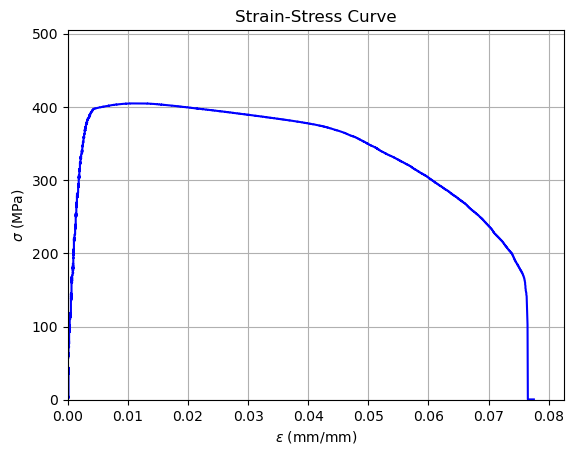

The LTR is 405 MPa
The elongation is 1.0584%
LinregressResult(slope=172111.28563767238, intercept=36.89378627325104, rvalue=0.9619172277649307, pvalue=0.0, stderr=588.8208655735872, intercept_stderr=0.3600781594106159)
The elastic modulus is 172 GPa
The yield stress is 398 MPa

.\data\Ensaios_2023_2-nTava
['grp1_vitor_Aluminio.txt', 'grupo 2 (karine,georg,matheus)_1020.txt']

arquivo: grp1_vitor_Aluminio.txt



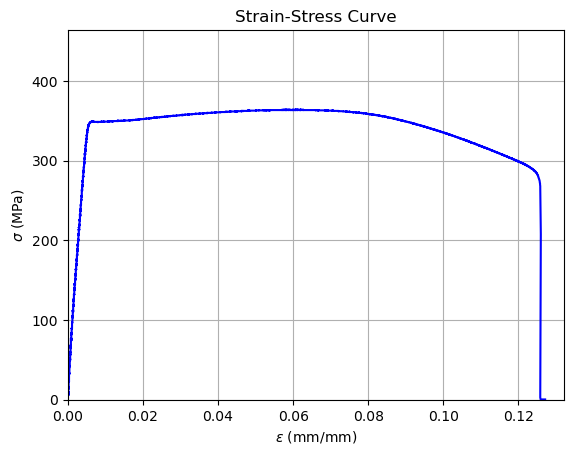

The LTR is 364 MPa
The elongation is 5.6976%
LinregressResult(slope=70103.29853395745, intercept=10.067110982944484, rvalue=0.9976616666923654, pvalue=0.0, stderr=64.71602069087841, intercept_stderr=0.11829652787017217)
The elastic modulus is 70 GPa
The yield stress is 349 MPa


arquivo: grupo 2 (karine,georg,matheus)_1020.txt



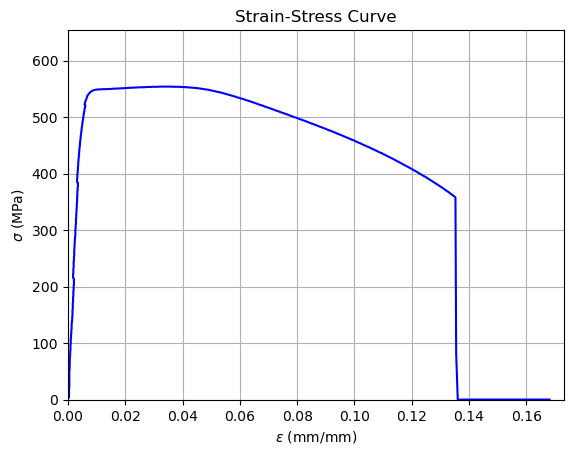

The LTR is 554 MPa
The elongation is 3.1956000000000007%
LinregressResult(slope=118960.06394577808, intercept=-20.982075476620764, rvalue=0.9922607255716325, pvalue=2.1870831641670493e-278, stderr=852.4102776224352, intercept_stderr=1.4549572756933207)
The elastic modulus is 119 GPa
The yield stress is 526 MPa



In [8]:
# Here runs it all, it will read the text/csv file from a paste called "data"
# Inside this paste, it will open another paste (or pastes) and then read the text file and return the properties with the Stress-Strain curve
# This part of the code funtions like this: will run until every single file inside every single paste inside the data paste is read and processed
rootdir = '.\data'
for diretorio in os.listdir(rootdir):
    d = os.path.join(rootdir, diretorio)
    if os.path.isdir(d):
        print(d)
        path = d
        files = [f for f in listdir(path) if isfile(join(path, f))]
        print(files)
        for arquivo in files:
            print('\narquivo: {0}\n'.format(arquivo))
            dfx = getData(path+'\\'+arquivo) 
            area,l0 = readParameters(path+'\\'+arquivo)
            runMetalsAnalysis(area,l0,dfx)
            print()